# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Целью проекта является построение модели определения рыночной стоимости 
для использования в приложении сервиса по продаже автомобилей с пробегом «Не бит, не крашен».   
Ожидается, что приложение позволит пользователям самостоятельно оценить стоимость автомобиля исходя из технических характеристик
 и комплектации.   
Для формирования модели были предоставлены исторические данные. На их основе предстоит обучить и протестировать различные модели
для выявления наилучшей с точки зрения качества  предсказания, скорости предсказания и времени обучения.  

План работы:  
1) Загрузка и изучение данных. Их подготовка и обработка (работа с пропусками и дублями, удаление неинформативных признаков).
Подготовка выборок данных для последующего обучения модели.  
2) Обучение моделей. В качестве обучаемых моделей будут взяты LightGBM с подбором наилучших гиперпатаметров и модель линейной регрессии 
3) Анализ характеристик модели. Оценка времени обучения, времени предсказания и качества моделей. 
В качестве ориентира оценки качества модели будет использована метрика RMSE в значениях меньше 2500.  
4) Выводы по проекту



In [1]:
# -q убирает необязательные выводы в командах Linux
!pip install shap -q 
!pip install lightgbm
!pip install catboost
!pip install scikit-learn --upgrade


## Подготовка данных

In [2]:
#импорт библиотек

import os
import pandas as pd
import numpy as np
import re
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from numpy.random import RandomState
from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
import lightgbm
import catboost
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

print(lightgbm.__version__)

4.3.0


In [3]:
#импорт файлов
pd.set_option('display.max_columns', 50) 
pth1_1 = '/datasets/autos.csv'
pth2_1 = 'autos.csv'

if os.path.exists(pth1_1):
    autos= pd.read_csv(pth1_1, sep=',', decimal=';')
elif os.path.exists(pth2_1):
    autos = pd.read_csv(pth2_1, sep=',', decimal=';')
else:
    print('Something is wrong')


In [4]:
display(autos.head(5))
autos.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
#явные дубли
display(autos.duplicated().sum())

4

In [6]:
autos = autos.drop_duplicates()
display(autos.duplicated().sum())

0

In [7]:
#самая ранняя дата регистрации объявления
display(min(autos['DateCreated']))

'2014-03-10 00:00:00'

В качестве дополнительного параметра зададим количество лет, сколько находилась машина во владении до момента выставления на продажу

In [8]:
autos['DateCreated'] = autos['DateCreated'].astype("datetime64[ns]")

In [9]:
autos['year_gap'] = -autos['RegistrationYear'] + autos['DateCreated'].dt.year
display(autos.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,year_gap
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800,11.765442
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078,90.228466
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,-7983.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000,8.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000,13.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000,17.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,1016.000000


Отрицательной разницы между годом регистрации анкеты и годом регистрации машины быть не может. Это точно записи с некорректным годом.  
Подлежит удалению.  

In [10]:
autos = autos.loc[autos['year_gap'] > 0]
display(autos.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,year_gap
count,330235.000000,330235.000000,330235.000000,330235.000000,330235.000000,330235.0,330235.000000,330235.000000
mean,4539.481509,2001.925280,111.916108,127898.254273,5.788714,0.0,50691.697004,14.074641
std,4564.323575,13.949037,182.514378,37946.529190,3.694518,0.0,25814.053112,13.949048
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,1.000000
25%,1137.500000,1999.000000,70.000000,125000.000000,3.000000,0.0,30179.000000,9.000000
50%,2850.000000,2002.000000,105.000000,150000.000000,6.000000,0.0,49565.000000,14.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71287.000000,17.000000
max,20000.000000,2015.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,1016.000000


Теперь можем удалить столбцы с датами

Даты создания объявления и последней активности сами по себе не являются релевантными.    
Но можно вычислить, сколько лет машина находилась во владении.  
После удалим все колонки, где указаны даты.     
Также из данных по дате регистрации нам достаточно года - удалим месяц регистрации.    
Количество изображений и почтовый код нерелевантны - удалим  

In [11]:
#удаление неинформативных характеристик

autos = autos.drop(['DateCrawled', 'RegistrationMonth', 'PostalCode', 'NumberOfPictures', 'LastSeen', 'DateCreated'], axis=1)
display(autos.head(5))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,year_gap
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,23
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,5
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,12
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,15
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,8


In [12]:
#приведём названия столбцов к нижнему регистру и адаптируем названия
autos.columns = autos.columns.str.lower()
display(autos.head(5))

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,year_gap
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,23
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,5
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,12
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,15
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,8


In [13]:
autos = autos.rename(columns={'vehicletype': 'vehicle_type', 
                              'registrationyear': 'registration_year', 
                              'fueltype': 'fuel_type', 
                              'datecreated': 'date_created', 
                              'lastseen': 'last_seen'})

In [14]:
autos.describe()

,price,registration_year,power,kilometer,year_gap
count,330235.000000,330235.000000,330235.000000,330235.000000,330235.000000
mean,4539.481509,2001.925280,111.916108,127898.254273,14.074641
std,4564.323575,13.949037,182.514378,37946.529190,13.949048
min,0.000000,1000.000000,0.000000,5000.000000,1.000000
25%,1137.500000,1999.000000,70.000000,125000.000000,9.000000
50%,2850.000000,2002.000000,105.000000,150000.000000,14.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,17.000000
max,20000.000000,2015.000000,20000.000000,150000.000000,1016.000000


Видим, что есть некорректные значения года регистрации. Посмотрим, сколько таких значений.

In [15]:
display(len(autos.loc[autos['registration_year'] > 2024]) + len(autos.loc[autos['registration_year'] < 1900]))

66

Значений с аномальным годом немного (66). Это важный параметр для обучения модели. Восстановить его нельзя. Удалим строки 

In [16]:
autos = autos.loc[autos['registration_year'] <= 2024]
autos = autos.loc[autos['registration_year'] >= 1900]
autos.describe()

,price,registration_year,power,kilometer,year_gap
count,330169.000000,330169.000000,330169.000000,330169.000000,330169.000000
mean,4540.100512,2002.089197,111.899609,127921.140386,13.910725
std,4564.348448,6.802942,182.411404,37912.869285,6.802961
min,0.000000,1910.000000,0.000000,5000.000000,1.000000
25%,1149.000000,1999.000000,70.000000,125000.000000,9.000000
50%,2850.000000,2002.000000,105.000000,150000.000000,14.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,17.000000
max,20000.000000,2015.000000,20000.000000,150000.000000,106.000000


Заполнение пропусков

In [17]:
#пропуски
display(autos.isna().sum())

price                    0
vehicle_type         13508
registration_year        0
gearbox              16573
power                    0
model                16318
kilometer                0
fuel_type            23564
brand                    0
repaired             60373
year_gap                 0
dtype: int64

Заполним пропуски в столбцах vehicle_type, gearbox и fuel_type близкими по моделям значениями

In [18]:
autos['vehicle_type'] = autos['vehicle_type'].fillna(autos
                                                  .groupby('model')['vehicle_type']
                                                  .transform(lambda x: x.value_counts().idxmax())
                                                 )

In [19]:
autos['fuel_type'] = autos['fuel_type'].fillna(autos
                                                  .groupby('model')['fuel_type']
                                                  .transform(lambda x: x.value_counts().idxmax())
                                                 )

In [20]:
autos['gearbox'] = autos['gearbox'].fillna(autos
                                                  .groupby('model')['gearbox']
                                                  .transform(lambda x: x.value_counts().idxmax())
                                                 )

In [21]:
display(autos.isna().sum())

price                    0
vehicle_type          3468
registration_year        0
gearbox               3443
power                    0
model                16318
kilometer                0
fuel_type             5416
brand                    0
repaired             60373
year_gap                 0
dtype: int64

In [22]:
display(len(autos.loc[autos['model'].isna()]) / len(autos))

0.04942317419261045

Пропусков в столбце model 5%. Эта характеристика важна для построения модели, поэтому строки с пропусками удалим.

Заполним пропуске в столбеце repaired  значением unknown

In [23]:
autos['repaired'] = autos['repaired'].fillna('unknown')

In [24]:
autos = autos.loc[~autos['model'].isna()]
display(autos.isna().sum())

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
year_gap             0
dtype: int64

In [25]:
display(autos['vehicle_type'].unique(),
        autos['gearbox'].unique(),
        autos['model'].unique(),
        autos['fuel_type'].unique(),
        autos['brand'].unique()
       )

array(['sedan', 'suv', 'small', 'convertible', 'bus', 'wagon', 'coupe',
       'other'], dtype=object)

array(['manual', 'auto'], dtype=object)

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'kadett', 'corsa', 'one', 'fortwo', 'clio', '1er',
       'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'polo', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'megane', 'lupo', 'r19', 'caddy',
       'mondeo', 'cordoba', 'colt', 'impreza', 'vectra', 'berlingo',
       'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe',
       'ceed', 'kangoo', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'fox', 'matiz', 'beetle', 'c1', 'rio',
       'touareg', 'logan

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'audi', 'alfa_romeo', 'subaru', 'volvo',
       'mitsubishi', 'kia', 'hyundai', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'porsche', 'rover', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

In [26]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313851 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              313851 non-null  int64 
 1   vehicle_type       313851 non-null  object
 2   registration_year  313851 non-null  int64 
 3   gearbox            313851 non-null  object
 4   power              313851 non-null  int64 
 5   model              313851 non-null  object
 6   kilometer          313851 non-null  int64 
 7   fuel_type          313851 non-null  object
 8   brand              313851 non-null  object
 9   repaired           313851 non-null  object
 10  year_gap           313851 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 28.7+ MB


Рассмотрим данные о цене. Посчитаем количество записей с нулевой ценой

In [27]:
display(len(autos.loc[autos['price'] == 0]), autos.loc[autos['price'] == 0])


7489

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,year_gap
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,36
40,0,small,1990,manual,0,corsa,150000,petrol,opel,unknown,26
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes,12
154,0,sedan,2006,manual,0,other,5000,petrol,fiat,unknown,10
231,0,wagon,2001,manual,115,mondeo,150000,petrol,ford,unknown,15
...,...,...,...,...,...,...,...,...,...,...,...
354205,0,small,2000,manual,65,corsa,150000,petrol,opel,yes,16
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,unknown,14
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,unknown,17
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes,17


Цена машины не может быть нулевой. Такие данные неинформативные для модели. Заполним нулевые цены близкими по модели

In [28]:
autos.loc[autos['price'] == 0, 'price'] = None
autos['price'] = autos['price'].fillna(autos.groupby('model')['price'].transform('median'))
display(len(autos.loc[autos['price'] == 0]), autos.loc[autos['price'] == 0])

0

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,year_gap


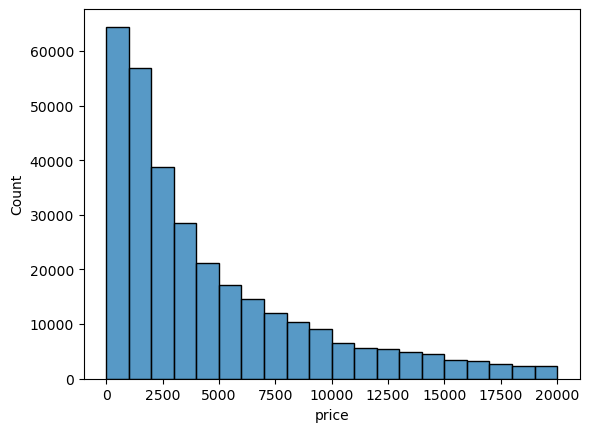

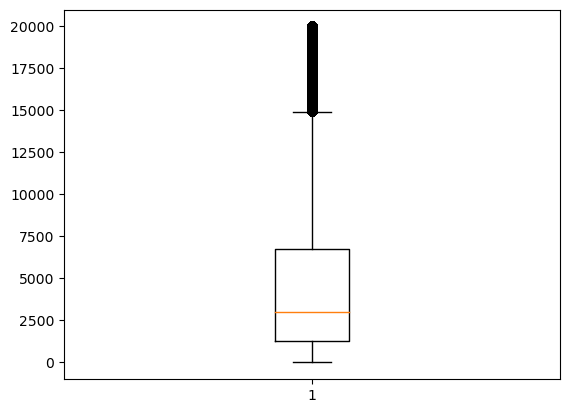

In [29]:
sns.histplot(autos['price'], bins=20)
plt.show()
plt.boxplot(autos['price'])
plt.show()

In [30]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313851 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              313851 non-null  float64
 1   vehicle_type       313851 non-null  object 
 2   registration_year  313851 non-null  int64  
 3   gearbox            313851 non-null  object 
 4   power              313851 non-null  int64  
 5   model              313851 non-null  object 
 6   kilometer          313851 non-null  int64  
 7   fuel_type          313851 non-null  object 
 8   brand              313851 non-null  object 
 9   repaired           313851 non-null  object 
 10  year_gap           313851 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 28.7+ MB


Рассмотрим данные по мощности. 
Посчитаем количество записей с аномальными мощностями. Аномальные данные заполним близкими по моделям значениями.
На текущий момент мощность машины не может привышать 2000 и не может быть нулевой или отрицательной

In [31]:
display(len(autos.loc[(autos['power'] > 2000) | (autos['power'] <= 0)]))

28610

In [32]:
autos.loc[(autos['power'] > 2000) | (autos['power'] <= 0), 'power'] = None
autos['power'] = autos['power'].fillna(autos.groupby('model')['power'].transform('median'))
autos = autos.loc[~autos['power'].isna()]


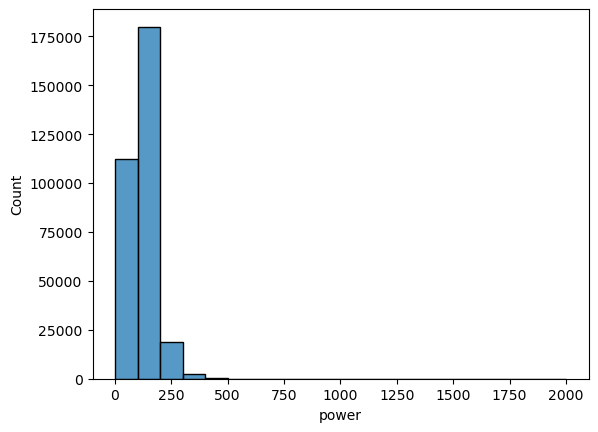

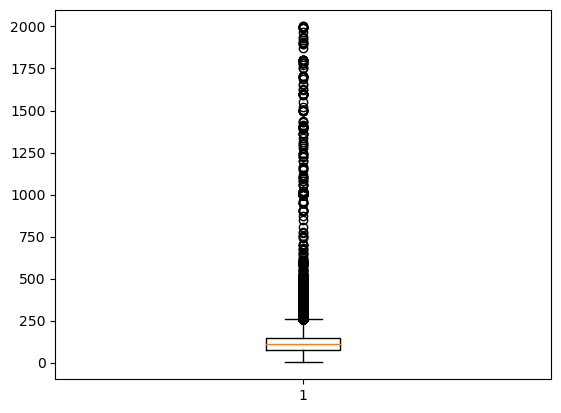

In [33]:
sns.histplot(autos['power'], bins=20)
plt.show()
plt.boxplot(autos['power'])
plt.show()

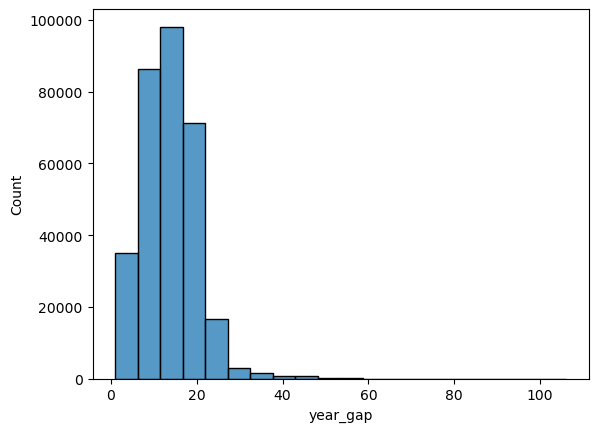

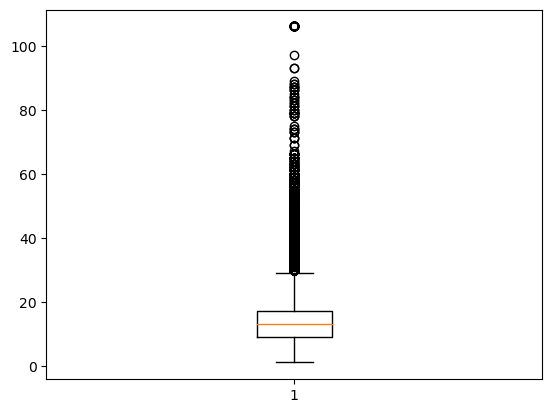

In [34]:
sns.histplot(autos['year_gap'], bins=20)
plt.show()
plt.boxplot(autos['year_gap'])
plt.show()

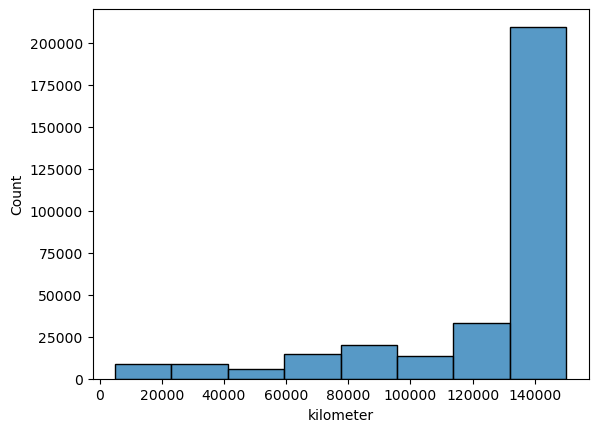

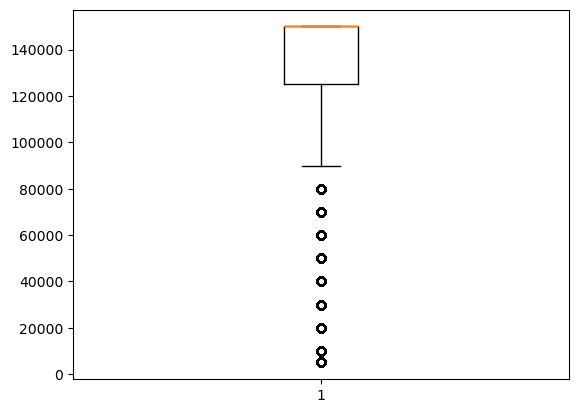

In [35]:
sns.histplot(autos['kilometer'], bins=8)
plt.show()
plt.boxplot(autos['kilometer'])
plt.show()

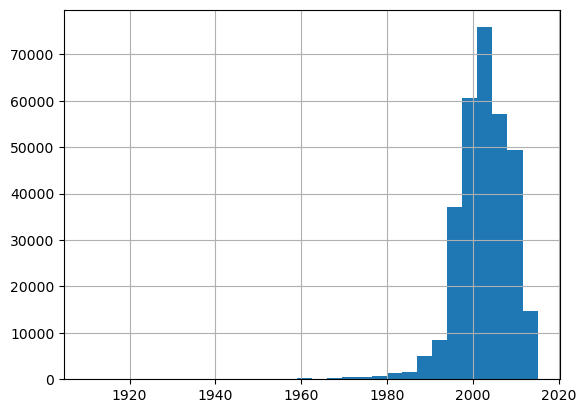

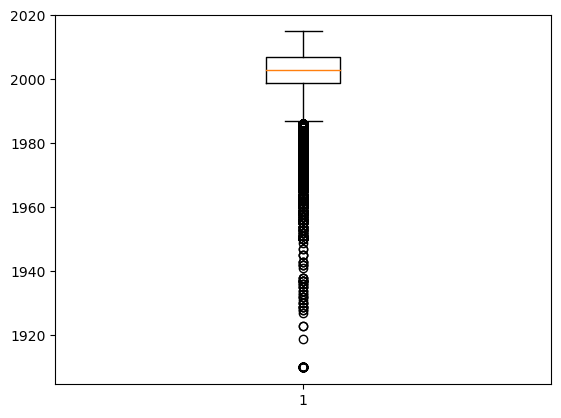

In [36]:
autos['registration_year'].hist(bins = 30)
plt.show()
plt.boxplot(autos['registration_year'])
plt.show()

In [37]:
display(autos.duplicated().sum())

47339

In [38]:
autos = autos.drop_duplicates()
display(autos.duplicated().sum())

0

In [39]:
display(autos.describe(), autos.info(), autos.head(5))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 266510 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              266510 non-null  float64
 1   vehicle_type       266510 non-null  object 
 2   registration_year  266510 non-null  int64  
 3   gearbox            266510 non-null  object 
 4   power              266510 non-null  float64
 5   model              266510 non-null  object 
 6   kilometer          266510 non-null  int64  
 7   fuel_type          266510 non-null  object 
 8   brand              266510 non-null  object 
 9   repaired           266510 non-null  object 
 10  year_gap           266510 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 24.4+ MB


,price,registration_year,power,kilometer,year_gap
count,266510.000000,266510.000000,266510.000000,266510.000000,266510.000000
mean,4830.950392,2002.350704,122.119027,126839.049191,13.649218
std,4611.620036,6.638444,62.631874,38144.064638,6.638458
min,1.000000,1910.000000,1.000000,5000.000000,1.000000
25%,1349.000000,1999.000000,80.000000,125000.000000,9.000000
50%,3150.000000,2003.000000,115.000000,150000.000000,13.000000
75%,6950.000000,2007.000000,150.000000,150000.000000,17.000000
max,20000.000000,2015.000000,2000.000000,150000.000000,106.000000


None

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,year_gap
0,480.0,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown,23
2,9800.0,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown,12
3,1500.0,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,15
4,3600.0,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,8
5,650.0,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,21


Изначальный файл с таблицей содержит 354369 записей и 16 характеристик.  
Привели название характеристик к нижнему регистру и адаптировали их.  
В столбцах vehicle_type, gearbox , fuel_type , были заполнены пропуски значениями, близкими по моделям.  
В столбце repaired пропуски были заполнены значением unknown.  
В столбце model записи с пропусками были удалены.
Аномальные значения в столбце power и price были заполнены медианными по моделям.  
В таблице присутствали неиформативные для обучения модели характеристики.  
Были удалены столбцы DateCrawled, RegistrationMonth, LastSeen, DateCreated. Вместо них была создана характеристика  
year_gap, обозначающую количество лет пока машина находилась во владении.
Также из временных категорий Month также не даст большого вклада.  
Для построения модели характеристики NumberOfPictures и PostalCode не релевантными - удалили эти столбцы.   
После обработки данных в таблице осталось 266510 записей. По ним подготовлены выборки для обучения модели.



#### Подготовка данных к обучению, формирование выборок

In [40]:
cat_list = ['vehicle_type','gearbox', 'fuel_type', 'brand', 'repaired', 'model']
num_list = ['registration_year', 'power', 'kilometer', 'year_gap']
df = autos.copy()


In [41]:
X = df.drop("price", axis=1)
y = df["price"]

In [42]:
#Отделение тестовой части
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)


In [43]:
#Отделения валидационной и обучающей выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, train_size =0.75)

Проведём масштабирование признаков к стандартному нормальному распределению с помощью StandardScaler

In [44]:
cat_col_names = ['vehicle_type','gearbox', 'fuel_type', 'brand', 'repaired', 'model']
num_col_names = ['registration_year', 'power', 'kilometer', 'year_gap']

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_valid_scaled = scaler.transform(X_valid[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

encoder = OneHotEncoder(drop='first', sparse_output=False)


X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_valid_ohe = encoder.transform(X_valid[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out() 


X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_valid = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [45]:
display(X_train.shape, X_valid.shape)

(159906, 306)

(53302, 306)

Данные были разделены на тестовую и тренировочную выборки.  
Также данные были скалированы.
Переходим к обучению моделей.  

## Обучение моделей

### Линейная модель

In [46]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

CPU times: total: 10.2 s
Wall time: 1.74 s


LinearRegression()

In [47]:
%%time
preds_lr = lr.predict(X_valid)

CPU times: total: 750 ms
Wall time: 95 ms


In [48]:
mse_lr = mean_squared_error(y_valid, preds_lr)
display(round((mse_lr) ** 0.5, 2))

2761.28

In [49]:
%%time
parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr,parameters, cv=4, scoring = 'neg_root_mean_squared_error', verbose=False)
grid.fit(X_train, y_train)
grid.best_params_

CPU times: total: 2min 18s
Wall time: 20.9 s


{'copy_X': True, 'fit_intercept': True}

In [50]:
%%time
lr_tuned = LinearRegression(**grid.best_params_).fit(X_train, y_train)

CPU times: total: 10.9 s
Wall time: 1.59 s


In [51]:
print(round((-grid.best_score_), 2))

2764.04


In [52]:
%%time
lr_pred = lr_tuned.predict(X_valid)

CPU times: total: 250 ms
Wall time: 31 ms


In [53]:
rmse_lr_tuned = np.sqrt(mse(y_valid, lr_pred))
print("LinearRegression RMSE: %.2f" % round((-grid.best_score_), 2)) 

LinearRegression RMSE: 2764.04


### LightGBM

In [54]:
display(df.head(5))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,year_gap
0,480.0,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown,23
2,9800.0,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown,12
3,1500.0,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,15
4,3600.0,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,8
5,650.0,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,21


In [55]:
display(X_train.shape, X_test.shape)


(159906, 306)

(53302, 306)

In [56]:
%%time
train_data = lightgbm.Dataset(X_train, label=y_train, 
                              free_raw_data=False,
                              categorical_feature=cat_col_names)
test_data = lightgbm.Dataset(X_test, label=y_test)

param_grid = {'learning_rate': [0.1, 0.2, 0.4, 0.6],
              'max_depth': [15, 20, 25, 30],
             }

lgbm = lightgbm.LGBMRegressor(n_jobs = 8)

grid_search = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                           error_score='raise')
grid_search.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 159906, number of used features: 285
[LightGBM] [Info] Start training from score 4829.437538
CPU times: total: 4.47 s
Wall time: 27.5 s


GridSearchCV(cv=3, error_score='raise', estimator=LGBMRegressor(n_jobs=8),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.4, 0.6],
                         'max_depth': [15, 20, 25, 30]},
             scoring='neg_mean_squared_error')

In [57]:
print(grid_search.best_params_)

{'learning_rate': 0.4, 'max_depth': 20}


In [58]:
%%time
lgbm_tuned = lightgbm.LGBMRegressor(**grid_search.best_params_).fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 159906, number of used features: 285
[LightGBM] [Info] Start training from score 4829.437538
CPU times: total: 4.19 s
Wall time: 815 ms


In [59]:
%%time
preds_lgbm_tuned = lgbm_tuned.predict(X_valid)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: total: 1 s
Wall time: 128 ms


In [60]:
print(round(((-grid_search.best_score_) ** 0.5), 2))

1713.22


Среди двух моделей лучшей оказалась модель LGBM.
Проведём её тестирование на тестовой выборке

In [61]:
%%time
final_preds_lgbm = grid_search.best_estimator_.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: total: 1.08 s
Wall time: 174 ms


In [62]:
mse_lgbm1 = mean_squared_error(y_test, final_preds_lgbm)
display((round((mse_lgbm1) ** 0.5, 2)))

1676.57

## Анализ моделей

Были построены две модели - линейной регрессии и LGBM регрессии.  
Качество каждой из них было оценено метрикой RMSE и вычислено время обучения и работы моделей на валидационных данных.  
Получили следующие результаты:  
Метрика RMSE:  
    - линейная модель - 2764.04    
    - LGBM -1713.22       
Время обучения:  
    - линейная модель - 1.59 c   
    - LGBM - 0.815 с   
Время предсказания модели:    
    - линейная модель - 31 мс  
    - LGBM -128 мс   
Таким образом модель LGBM оказалась быстрее по побучению, медленее по предсказанию
и единственная удовлетворила критерию качества предсказания RMSE < 2500    

Лучшая модель была протестирована на тестовой выборке.   
Получили метрику RMSE = 1676.57

### Общий итог  
В ходе исследования были предприняты следующие действия:  
1) Были загружены исходные данные, обработаны пропуски, дубли, аномальные значения.   
Данные были разбиты на тренировочную и тестовую выборки и подготовлены к обучению моделей.
2) Были обучены две модели: LightGBM с подбором наилучших гиперпатаметров и модель линейной регресии.   
    Также были созданы предсказания моеделей. 
    
3) Анализ характеристик требовал сопоставления времени обучения и составления предсказания, а также метрик RMSE.  
Произведён замер количества времени, затрачеваемого на обучения:  
    - линейная модель - 1.59 c   
    - LGBM - 0.815 с  
    Линейная модель справляется быстрее с обучением.  
    Также моделями были сделаны предсказание также с замером затрачиваемого времени:  
    - линейная модель - 31 мс  
    - LGBM -128 мс       
    Линейная модель составляет предсказание быстрее  
    Сами предсказания были оценены с помощью метрики RMSE,  которая по заданию должна оказаться меньше 2500.  
    Метрика RMSE:  
    - линейная модель - 2764.04    
    - LGBM -1713.22     
    Видим, что условию удовлетворяет только метрика модели LGBM с гиперпараметрами 'learning_rate': 0.4 и 'max_depth': 20.     
 4) Сопоставляя качество и скорость работы двух моделей выявили, что модель LGBM обучается быстрее, 
составляет предсказания медленее модели линейной регрессии. Также предсказания модели LGBM точнее и 
единственные из двух удовлетворяют критерию LGBN < 2500  
Лучшая модель была протестирована на тестовой выборке.   
Получили метрику RMSE = 1676.57  
Таким образом для прогнозирования стоимости машины в программе рассчёта стоит использовать модель LGBM.